In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

In [2]:
data_path = 'Bike-Sharing-Dataset/hour.csv'

rides = pd.read_csv(data_path)

In [3]:
rides.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


In [4]:
dummy_fields = ['season', 'weathersit', 'mnth', 'hr', 'weekday']
for each in dummy_fields:
    dummies = pd.get_dummies(rides[each], prefix=each, drop_first=False)
    rides = pd.concat([rides, dummies], axis=1)

fields_to_drop = ['instant', 'dteday', 'season', 'weathersit', 
                  'weekday', 'atemp', 'mnth', 'workingday', 'hr']
data = rides.drop(fields_to_drop, axis=1)
data.head()

,yr,holiday,temp,hum,windspeed,casual,registered,cnt,season_1,season_2,...,hr_21,hr_22,hr_23,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
0,0,0,0.24,0.81,0.0,3,13,16,1,0,...,0,0,0,0,0,0,0,0,0,1
1,0,0,0.22,0.80,0.0,8,32,40,1,0,...,0,0,0,0,0,0,0,0,0,1
2,0,0,0.22,0.80,0.0,5,27,32,1,0,...,0,0,0,0,0,0,0,0,0,1
3,0,0,0.24,0.75,0.0,3,10,13,1,0,...,0,0,0,0,0,0,0,0,0,1
4,0,0,0.24,0.75,0.0,0,1,1,1,0,...,0,0,0,0,0,0,0,0,0,1


In [5]:
quant_features = ['casual', 'registered', 'cnt', 'temp', 'hum', 'windspeed']
# Store scalings in a dictionary so we can convert back later
scaled_features = {}
for each in quant_features:
    mean, std = data[each].mean(), data[each].std()
    scaled_features[each] = [mean, std]
    data.loc[:, each] = (data[each] - mean)/std

In [6]:
# Save the last 21 days 
test_data = data[-21*24:]
data = data[:-21*24]

# Separate the data into features and targets
#target_fields = ['cnt', 'casual', 'registered']
target_fields = ['cnt']
features, targets = data.drop(target_fields, axis=1), data[target_fields]
test_features, test_targets = test_data.drop(target_fields, axis=1), test_data[target_fields]

In [7]:
features = features.values
targets = targets.values
test_features = test_features.values
test_targets = test_targets.values

In [8]:
# Hold out the last 60 days of the remaining data as a validation set
train_features, train_targets = features[:-60*24], targets[:-60*24]
val_features, val_targets = features[-60*24:], targets[-60*24:]

In [9]:
print("features ", train_features.shape)
print("labels", train_targets.shape)
#print (train_targets[0:2, :])

features  (15435, 58)
labels (15435, 1)


# To reshape input data for a LTSM nn
1. Split the data into n_batches, and stack them


In [10]:
batch_size = 5
n_steps = 48 # 2 days
n_lstms = 2
num_layers = 2

In [11]:
'''
def reshape_data(data, batch_size):
    return np.transpose(np.stack(np.split(data, batch_size)), [1,0,2])

train_features = reshape_data(train_features, batch_size)
train_targets = reshape_data(train_targets, batch_size)
'''

'\ndef reshape_data(data, batch_size):\n    return np.transpose(np.stack(np.split(data, batch_size)), [1,0,2])\n\ntrain_features = reshape_data(train_features, batch_size)\ntrain_targets = reshape_data(train_targets, batch_size)\n'

In [12]:
print(train_features.shape, train_targets.shape)
print (tf.__version__)

(15435, 58) (15435, 1)
1.0.0


In [13]:
#x = tf.placeholder(tf.float32, shape=[batch_size * n_steps, train_features.shape[-1]], name = 'x')
#y = tf.placeholder(tf.float32, shape=[batch_size * n_steps, train_targets.shape[-1]], name = 'y')
x = tf.placeholder(tf.float32, shape=[None, train_features.shape[-1]], name = 'x')
y = tf.placeholder(tf.float32, shape=[None, train_targets.shape[-1]], name = 'y')
keep_prob = tf.placeholder(tf.float32, name='keep_prob')
print ("x:{} y:{}".format(x.shape, y.shape))
#x = tf.transpose(x, [1,0,2])
#x = tf.reshape(x, [-1, train_features.shape[-1]])
#print ("x:", x.shape)
rnn_inputs = tf.split(x, n_steps, 0)
#labels = tf.split(y, n_steps, 0)
print ("rnn_inputs:", len(rnn_inputs), rnn_inputs[0].shape)


x:(?, 58) y:(?, 1)
rnn_inputs: 48 (?, 58)


In [14]:
#build the model
# Use a basic LSTM cell
lstm = tf.contrib.rnn.BasicLSTMCell(n_lstms)
 
# Add dropout to the cell
drop = tf.contrib.rnn.DropoutWrapper(lstm, output_keep_prob=keep_prob)
    
# Stack up multiple LSTM layers, for deep learning
cell = tf.contrib.rnn.MultiRNNCell([drop] * num_layers)
initial_state = cell.zero_state(batch_size, tf.float32)

### Run the data through the RNN layers
# This makes a list where each element is on step in the sequence
#rnn_inputs = [tf.squeeze(i, squeeze_dims=[1]) for i in tf.split(x_one_hot, num_steps, 1)]
#rnn_inputs = tf.transpose(x, [1,0,2])
    
    # Run each sequence step through the RNN and collect the outputs
outputs, state = tf.contrib.rnn.static_rnn(cell, rnn_inputs, initial_state=initial_state)
final_state = state
print ("outputs", len(outputs), outputs[0].shape)
fc_inputs = tf.reshape(tf.concat(outputs, 1), [-1, n_lstms])
fc = tf.contrib.layers.fully_connected(fc_inputs, 4, activation_fn=tf.sigmoid)
preds = tf.contrib.layers.fully_connected(fc, 1, activation_fn=None)
#preds = tf.concat(preds, 0)
print (preds.shape)

outputs 48 (5, 2)
(240, 1)


In [15]:
cost = tf.sqrt(tf.reduce_mean(tf.square(tf.subtract(y, preds))))
optimizer = tf.train.AdamOptimizer().minimize(cost)

In [16]:
def get_batch(x, y, batch_size, n_steps):
    size = batch_size * n_steps
    for b in range(len(x)//size):
        yield x[b*size:(b+1)*size, :], y[b*size:(b+1)*size, :]

In [17]:
epochs = 48

with tf.Session() as sess:
    # Initializing the variables
    sess.run(tf.global_variables_initializer())
    print (val_features.shape)
    # Training cycle
    for epoch in range(epochs):
        for batch_features, batch_labels in get_batch(train_features, train_targets, batch_size, n_steps):
            #print ("batch:", batch_features.shape, batch_labels.shape)
            sess.run(optimizer, feed_dict = {x: batch_features, y: batch_labels, keep_prob:1.0})
        
        
        #val_cost = sess.run(preds, feed_dict={x:val_features, y:val_targets, keep_prob:1.0})
        #print ("valid_cost:", val_cost)
    y_1 = sess.run(preds, feed_dict={x:test_features[0:240,:], y:test_targets[0:240,:], keep_prob:1.0}) 
    y_2 = sess.run(preds, feed_dict={x:test_features[240:480,:], y:test_targets[240:480,:], keep_prob:1.0}) 
    y_ = np.concatenate([y_1, y_2], axis=0)
    print ("y_:", y_.shape)    

(1440, 58)
y_: (480, 1)


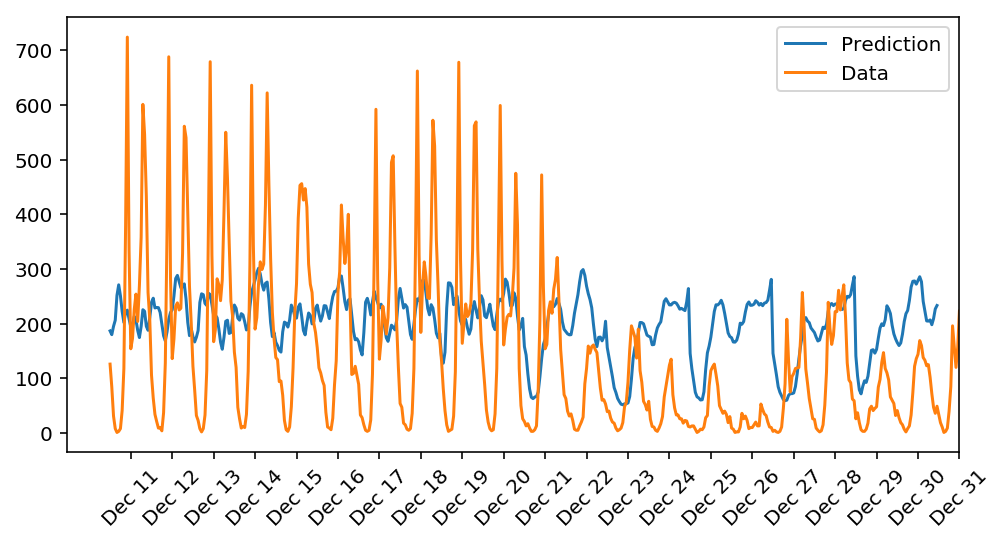

In [19]:
fig, ax = plt.subplots(figsize=(8,4))

mean, std = scaled_features['cnt']
predictions = y_*std + mean
ax.plot(predictions, label='Prediction')
ax.plot((test_targets*std + mean), label='Data')
ax.set_xlim(right=len(predictions))
ax.legend()

dates = pd.to_datetime(rides.ix[test_data.index]['dteday'])
dates = dates.apply(lambda d: d.strftime('%b %d'))
ax.set_xticks(np.arange(len(dates))[12::24])
_ = ax.set_xticklabels(dates[12::24], rotation=45)